In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression


In [2]:
data_dir = "/home/ubuntu/project_comp/data_window"


In [3]:
cell_type = "HepG2"
tf = "FOXA1"
window_size = 400
step_size = 40
temperature = 200
offset = 800


In [4]:
atac_file = [
    f"{data_dir}/{cell_type}/ATAC-seq/{i}"
    for i in os.listdir(f"{data_dir}/{cell_type}/ATAC-seq")
    if i.startswith(f"{window_size}_{step_size}")
][0]
chip_file = [
    f"{data_dir}/{cell_type}/{tf}/{i}"
    for i in os.listdir(f"{data_dir}/{cell_type}/{tf}")
    if i.startswith(f"{window_size}_{step_size}")
][0]
motif_pos_file = f"{data_dir}/motif/hg38/{tf}/{window_size}_{step_size}_{temperature}_{offset}_pos.npz"
motif_neg_file = f"{data_dir}/motif/hg38/{tf}/{window_size}_{step_size}_{temperature}_{offset}_neg.npz"

atac = np.load(atac_file)
chip = np.load(chip_file)
motif_pos = np.load(motif_pos_file)
motif_neg = np.load(motif_neg_file)

In [5]:
chr_ = "chr6"

atac_seq_data = atac[chr_]
chip_seq_data = chip[chr_]
motif_scan_pos_data = motif_pos[chr_]
motif_scan_neg_data = motif_neg[chr_]

In [6]:
motif_scan_pos_data.shape
motif_scan_pos_data.shape

(4270140,)

In [7]:
data = pd.DataFrame(
    {
        "ATAC_seq": atac_seq_data,
        "ChIP_seq": chip_seq_data,
        "Motif_scan_pos": motif_scan_pos_data,
        "Motif_scan_neg": motif_scan_neg_data,
    }
)
print(data.shape)
data.dropna(inplace=True)
print(data.shape)


(4270140, 4)
(3691395, 4)


In [8]:
data_high = data.loc[~(data <= data.quantile(0.9)).all(axis=1)]

data_high.shape, data.shape

((1258475, 4), (3691395, 4))

<AxesSubplot: >

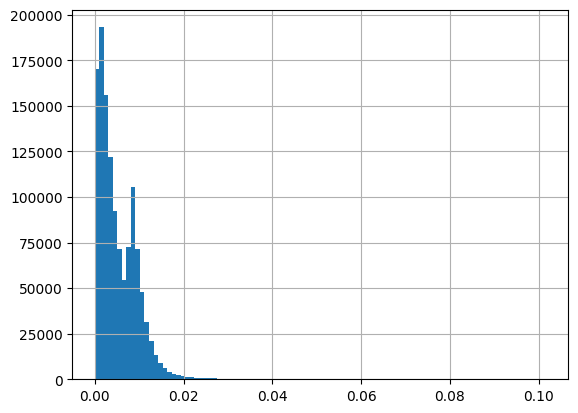

In [28]:
data_high.Motif_scan_pos.hist(bins=100)

## Stochastic Variational Gaussian Process

In [ ]:
import tqdm
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

# Make plots inline
%matplotlib inline

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [ ]:
import urllib.request
import os
from scipy.io import loadmat
from math import floor


# this is for running the notebook in our testing framework
smoke_test = "CI" in os.environ

if smoke_test:  # this is for running the notebook in our testing framework
    X, y = torch.randn(1000, 3), torch.randn(1000)
else:
    # data = torch.Tensor(loadmat('../elevators.mat')['data'])
    # X = data[:, :-1]
    # X = X - X.min(0)[0]
    # X = 2 * (X / X.max(0)[0]) - 1
    # y = data[:, -1]
    # X, y = torch.randn(1000000, 3), torch.randn(1000000)

    # X = torch.from_numpy(
    #     data_high[["ATAC_seq", "Motif_scan_pos", "Motif_scan_neg"]].to_numpy()
    # )
    # y = torch.from_numpy(data_high["ChIP_seq"].to_numpy())

    n = 100  # number of points in each dimension
    x = torch.linspace(0, 1, n)
    X = torch.stack(torch.meshgrid(x, x, x)).reshape(3, -1).T

    # True function is sin(2*pi*(x0+x1+x2))
    x0 = X[:, 0]
    x1 = X[:, 1]
    x2 = X[:, 2]
    y = torch.sin((x0 + x1 + x2) * (2 * math.pi)) + torch.randn_like(x0) * 0.01

train_n = int(floor(0.8 * len(X)))
train_x = X[:train_n, :].contiguous()
train_y = y[:train_n].contiguous()

test_x = X[train_n:, :].contiguous()
test_y = y[train_n:].contiguous()

if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = (
        train_x.cuda(),
        train_y.cuda(),
        test_x.cuda(),
        test_y.cuda(),
    )


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=65536, shuffle=True)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size=65536, shuffle=False)

In [ ]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy


class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(
            inducing_points.size(0)
        )
        variational_strategy = VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True,
        )
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


inducing_points = train_x[:500, :]
model = GPModel(inducing_points=inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()


In [ ]:
num_epochs = 1 if smoke_test else 4


model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))


epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
losses = []
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        losses.append(loss.item())
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()

plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')

In [ ]:
model.eval()
likelihood.eval()
means = torch.tensor([0.])
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    for x_batch, y_batch in test_loader:
        preds = model(x_batch)
        means = torch.cat([means, preds.mean.cpu()])
means = means[1:]

In [ ]:
print('Test MAE: {}'.format(torch.mean(torch.abs(means - test_y.cpu()))))


In [ ]:
data_high.ATAC_seq.hist(bins=100)

In [ ]:
data_high.ATAC_seq.quantile(0.8), data_high.ATAC_seq.quantile(0.95), data_high.ATAC_seq.quantile(0.98), data_high.ATAC_seq.quantile(0.995)

In [ ]:
data_high.Motif_scan_pos.hist(bins=100)

In [ ]:
data_high.Motif_scan_neg.hist(bins=100)


In [ ]:
def create_test_grid(n, atac_value, motif_max):
    atac = torch.full([n * n], atac_value)
    motif_pos = torch.linspace(0, motif_max, n)
    motif_neg = torch.linspace(0, motif_max, n)
    grid_motif_pos, grid_motif_neg = torch.meshgrid(motif_pos, motif_neg)
    test_x = torch.stack(
        [atac, grid_motif_pos.flatten(), grid_motif_neg.flatten()], dim=1
    )
    return grid_motif_pos, grid_motif_neg, test_x


def plot_interval_given_atac(atac_value, motif_max):
    X, Y, test_x = create_test_grid(n, atac_value=atac_value, motif_max=motif_max)
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        for x_batch, y_batch in test_loader:
            predictions = likelihood(model(test_x))
            mean = predictions.mean
            lower, upper = predictions.confidence_region()

    mean_grid = mean.view(n, n)
    lower_grid = lower.view(n, n)
    upper_grid = upper.view(n, n)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    mean_surf = ax.plot_surface(X, Y, mean_grid, color='darkorange')
    lower_surf = ax.plot_surface(X, Y, lower_grid, color='gray', alpha=0.3)
    upper_surf = ax.plot_surface(X, Y, upper_grid, color='gray', alpha=0.3)

    # Create proxy artists for the legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='blue', lw=2, label='Predictive Mean'),
        Line2D([0], [0], color='gray', lw=2, label='Confidence Bound'),
    ]

    ax.legend(handles=legend_elements, loc='upper left')
    return fig, ax


In [ ]:
motif_max = 0.1
n = 100
atac_low = 2
atac_medium_low = 20
atac_medium_high = 100
atac_high = 400

In [ ]:
fig, ax = plot_interval_given_atac(atac_value=0.1, motif_max=1)

In [ ]:
plot_interval_given_atac(atac_value=atac_low, motif_max=motif_max)

In [ ]:
plot_interval_given_atac(atac_medium_low)


In [ ]:
plot_interval_given_atac(atac_medium_high)


In [ ]:
plot_interval_given_atac(atac_high)


## Random forest

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap

In [10]:

# Assuming your data is loaded into the DataFrame named 'data'
# data = pd.DataFrame(...)

# Prepare the input and output data
X = data_high[["ATAC_seq", "Motif_scan_pos", "Motif_scan_neg"]]
y = data_high["ChIP_seq"]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=5, random_state=42)
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)


In [11]:
from scipy.stats import spearmanr

In [12]:
spearman_corr, p_value = spearmanr(y_test, y_pred)
permute = np.arange(len(y_pred))
np.random.shuffle(permute)
spearman_corr_permute, _ = spearmanr(y_test, y_pred[permute])
print(spearman_corr, spearman_corr_permute)

0.47175242096119624 0.0002755013831814463


In [13]:
from scipy.stats import rankdata

<AxesSubplot: >

Creating legend with loc="best" can be slow with large amounts of data.
Creating legend with loc="best" can be slow with large amounts of data.


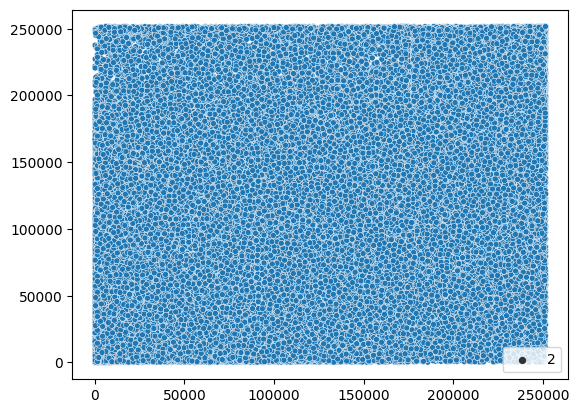

In [14]:
sns.scatterplot(x=rankdata(y_test), y=rankdata(y_pred), size=2)

In [23]:
y_pred.argsort()

array([155657, 248482,   3535, ..., 148349, 100340, 222325])

In [27]:
# Calculate the SHAP values for the RandomForestRegressor

sample_size = 100
# choose samples with top 1% and bottom 1% predicted values
X_test_sample_high = X_test.iloc[y_pred.argsort()[-sample_size:]]
X_test_sample_low = X_test.iloc[y_pred.argsort()[:sample_size]]
# combine them
X_test_sample = pd.concat([X_test_sample_high, X_test_sample_low])

explainer = shap.TreeExplainer(rf)
shap_values_high = explainer(X_test_sample)
# shap_values_low = explainer(X_test_sample_low)



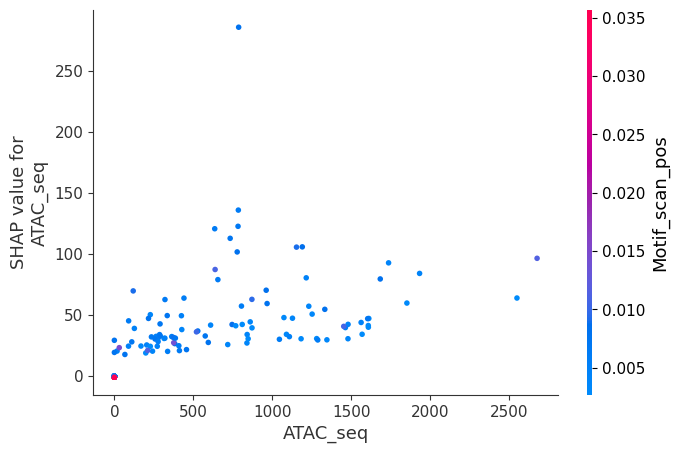

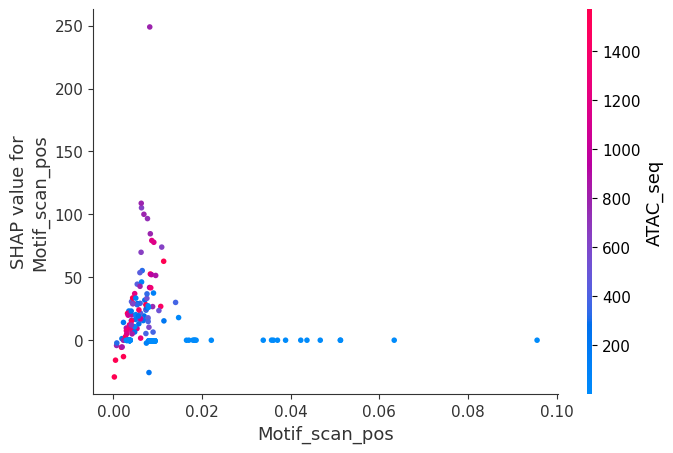

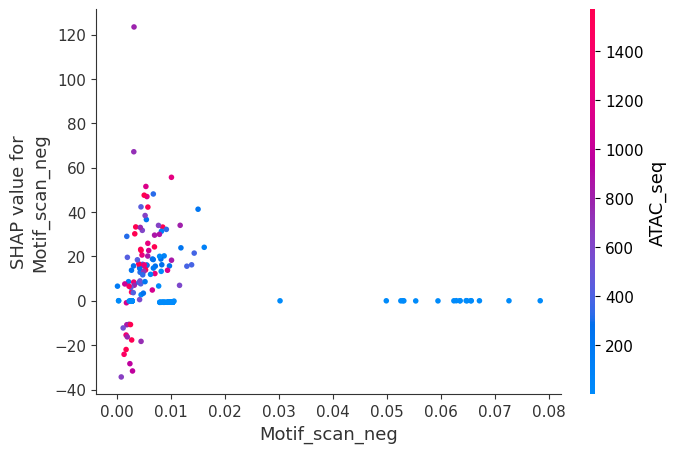

In [30]:
# Plot the dependency plots
for feature in X.columns:
    shap.dependence_plot(feature, shap_values_high.values, X_test_sample)

In [18]:
# Plot the SHAP values for a single prediction
shap.plots.waterfall(shap_values[0])

AttributeError: 'numpy.ndarray' object has no attribute 'base_values'

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


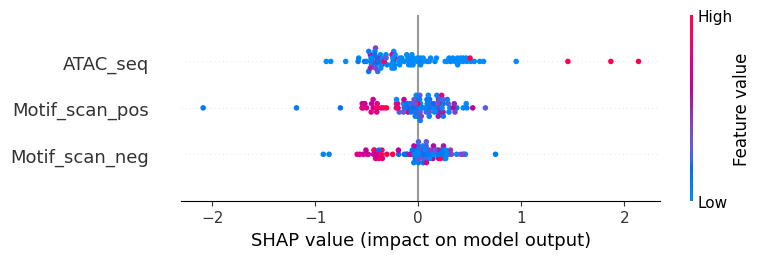

In [16]:
# Plot the summary of SHAP values for all features
shap.summary_plot(shap_values, X_test_sample)